
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
#loading in my data from yesterday's workload.
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import pandas as pd
DATA_PATH = '../data/'
df = pd.read_csv(DATA_PATH+'/fatal-police-shootings-data.csv')
print(df.shape)
df.head()

(5408, 14)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [4]:
#Choose your target. For this, I want to see if I can predict Race.
target = 'race'
print(df['race'].value_counts())
print(df['race'].isnull().sum())
df['race']
#This will be a Classification, there are 6 different races listed. 
#Baseline accuracy. White is the most common race, so its the baseline. 45.73% 
#Accuracy won't be quite good, probably be using Recall/Precision.
2473 / 5408

W    2473
B    1296
H     902
A      93
N      78
O      48
Name: race, dtype: int64
518


0.4572855029585799

In [5]:
data = {'state': ['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA',
                 'KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
                 'NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT',
                 'VA','WA','WV','WI','WY'],
       'H':[4.1,7.0,31.4,7.4,39.1,21.5,16.1,9.3,11.0,25.6,9.6,10.5,12.4,17.2,6.9,5.9,11.9,
            3.5,5.2,1.6,10.1,11.8,5.1,5.3,2.9,4.2,3.7,10.9,28.8,3.8,20.4,48.8,19.2,9.4,3.5,3.7,10.6,
           13.1,7.3,15.4,5.7,3.6,5.4,39.4,14.0,1.9,9.3,12.7,1.3,6.9,10.0],
       'W':[65.5,60.6,54.7,72.3,37.0,68.2,66.7,62.2,36.5,53.8,52.6,21.8,82.0,61.2,79.2,85.9,75.9,
           84.6,58.5,93.4,50.7,71.5,75.0,79.9,56.6,79.4,86.3,79.0,48.8,90.3,54.8,37.4,55.1,63.0,84.4,
           78.9,65.6,75.6,76.4,72.1,63.6,82.3,73.9,41.9,78.3,92.8,61.7,68.6,92.0,81.2,84.0],
       'B':[26.7,2.9,4.1,15.2,5.5,3.9,9.9,21.5,45.3,15.4,31.1,1.6,.6,14.0,9.2,3.3,5.5,8.0,32.1,1.2,
           29.4,7.0,13.6,6.4,37.9,11.4,.4,4.5,8.9,1.3,12.8,1.8,14.3,21.2,3.0,12.2,7.2,1.8,10.7,5.4,
           26.8,1.9,16.6,11.8,1.2,1.2,18.8,3.5,3.9,6.3,.9],
       'A':[1.3,6.6,3.2,1.6,14.4,3.1,4.5,4.0,4.0,2.8,3.9,37.3,1.3,5.4,2.2,2.6,2.9,1.4,1.8,1.1,6.4,6.6,
           3.1,4.9,.9,2.0,.7,2.4,8.3,2.7,9.8,1.3,8.7,2.9,1.7,2.2,2.1,4.3,3.5,3.6,1.5,1.2,1.8,4.8,2.4,
           1.8,6.4,8.5,.8,2.7,.8],
       'N':[.5,14.2,3.9,.6,.4,.6,.2,.2,.2,.2,.2,.1,1.1,.1,.1,.2,.6,.2,.5,.6,.2,.1,.5,1.0,.4,.3,5.9,.7,
           .9,.1,.1,8.8,.2,1.1,5.4,.2,7.3,.9,.1,.3,.2,8.6,.2,.3,1.0,.3,.2,1.0,.1,.8,2.1]}
racial_demographics = pd.DataFrame(data, columns=['state','H','W','B','A','N'])

In [6]:
racial_demographics['O'] = 100 - (racial_demographics['H'] + racial_demographics['W'] + racial_demographics['B'] 
+ racial_demographics['A'] + racial_demographics['N'])
racial_demographics

,state,H,W,B,A,N,O
0,AL,4.1,65.5,26.7,1.3,0.5,1.9
1,AK,7.0,60.6,2.9,6.6,14.2,8.7
2,AZ,31.4,54.7,4.1,3.2,3.9,2.7
3,AR,7.4,72.3,15.2,1.6,0.6,2.9
4,CA,39.1,37.0,5.5,14.4,0.4,3.6
5,CO,21.5,68.2,3.9,3.1,0.6,2.7
6,CT,16.1,66.7,9.9,4.5,0.2,2.6
7,DE,9.3,62.2,21.5,4.0,0.2,2.8
8,DC,11.0,36.5,45.3,4.0,0.2,3.0
9,FL,25.6,53.8,15.4,2.8,0.2,2.2


In [7]:
import numpy as np
def wrangle(X):
    X=X.copy()
    X['date'] = pd.to_datetime(X['date'], infer_datetime_format=True)
    cols_with_nans = ['armed','gender','flee']
    cols_for_age = ['age']
    for cols in cols_with_nans:
        X[cols] = X[cols].replace(np.nan, 'Unknown')
    mean = X['age'].dropna().sum() / len(X['age'])
    X['age'] = X['age'].replace(np.nan, mean)
    return X, mean
wrangled, mean = wrangle(df)
type(wrangled)

pandas.core.frame.DataFrame

In [10]:
scratch_df = wrangled.copy()
scratch_df = pd.merge(scratch_df, racial_demographics,left_on='state',right_on='state', how='left')
print(scratch_df['race'].value_counts())
scratch_df

W    2473
B    1296
H     902
A      93
N      78
O      48
Name: race, dtype: int64


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,H,W,B,A,N,O
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,12.7,68.6,3.5,8.5,1.0,5.7
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,13.1,75.6,1.8,4.3,0.9,4.3
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,11.9,75.9,5.5,2.9,0.6,3.2
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,39.1,37.0,5.5,14.4,0.4,3.6
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,21.5,68.2,3.9,3.1,0.6,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,5912,Jerry Bethel,2020-06-10,shot,gun,59.0,M,NaN,Weippe,ID,False,attack,Unknown,False,12.4,82.0,0.6,1.3,1.1,2.6
5404,5913,Gregorio Cruz Vanloo,2020-06-11,shot,gun,28.0,M,W,DeKalb County,TN,False,attack,Other,False,5.4,73.9,16.6,1.8,0.2,2.1
5405,5914,Mason James Lira,2020-06-11,shot,gun,26.0,M,W,Paso Robles,CA,True,attack,Not fleeing,False,39.1,37.0,5.5,14.4,0.4,3.6
5406,5915,"Michael ""Blue"" Thomas",2020-06-11,shot,undetermined,62.0,M,B,Lancaster,CA,False,undetermined,Not fleeing,False,39.1,37.0,5.5,14.4,0.4,3.6


In [26]:
demo= []
counter= 0
for i in range(5408):
    race = scratch_df.iloc[i][7]
    if race == 'H':
        var = 14
    elif race == 'W':
        var = 15
    elif race == 'B':
        var = 16
    elif race == 'A':
        var = 17
    elif race == 'N':
        var = 18
    else:
        var = 19
     
    value = scratch_df.iloc[i][var]
    demo.append(value)
scratch_df['demo'] = demo

In [37]:
for_testing = scratch_df.dropna()
for_testing.isnull().sum()

id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
H                          0
W                          0
B                          0
A                          0
N                          0
O                          0
demo                       0
dtype: int64

In [38]:
from sklearn.model_selection import train_test_split

base, test = train_test_split(for_testing, test_size=.15, random_state=1)
train, val = train_test_split(base, test_size=.2, random_state=1)
train.shape, val.shape, test.shape

((3324, 21), (832, 21), (734, 21))

In [53]:
columns_to_drop = ['id', 'name', 'race', 'date', 'H', 'W','B','A','N','O']
X_train = train.drop(columns=columns_to_drop, axis=1)
y_train = train[target]
X_val = val.drop(columns=columns_to_drop, axis=1)
y_val = val[target]
X_test = test.drop(columns=columns_to_drop, axis=1)
y_test = test[target]
X_train.shape, y_train.shape

((3324, 11), (3324,))

In [54]:
y_train.isnull().sum()

0

In [55]:
pipeline = make_pipeline(ce.OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                        RandomForestClassifier())
pipeline.fit(X_train, y_train)
param = {'randomforestclassifier__n_estimators': range(50,500),
        'randomforestclassifier__max_depth':[5,10,15,20,None],
        'randomforestclassifier__max_features':uniform(0,1),
        'randomforestclassifier__min_samples_leaf':[1,10,100],}
randomized_rfc = RandomizedSearchCV(pipeline, param_distributions= param,
                                   n_iter=100, cv=5, scoring='accuracy',
                                   verbose=10, return_train_score=True,
                                   n_jobs=-1)
randomized_rfc.fit(X_train, y_train)
print('Train accuracy for randomized:', randomized_rfc.score(X_train, y_train))
print('Validation Accuracy for Randomized:', randomized_rfc.score(X_val, y_val))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Train accuracy for randomized: 1.0
Validation Accuracy for Randomized: 0.9783653846153846


In [56]:
print('Best hyperparameters',randomized_rfc.best_params_)


Best hyperparameters {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 0.8447495939805454, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 331}


In [57]:
xgb = make_pipeline(ce.OrdinalEncoder(),
                   XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1))
xgb.fit(X_train, y_train)
print('Train accuracy:',xgb.score(X_train, y_train))
print('Validation Accuracy:', xgb.score(X_val, y_val))
#model = xgb.best_estimator_

Train accuracy: 0.9663056558363418
Validation Accuracy: 0.9507211538461539


In [59]:
row = X_val.iloc[[15]]
model= randomized_rfc.best_estimator_
model.predict(row)

array(['W'], dtype=object)

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
y_pred = xgb.predict(X_val)

In [64]:
import seaborn as sns
features = X_train.columns
X = X_train
y = y_train
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)
model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_encoded, y)


RandomForestClassifier(n_jobs=-1, random_state=1)

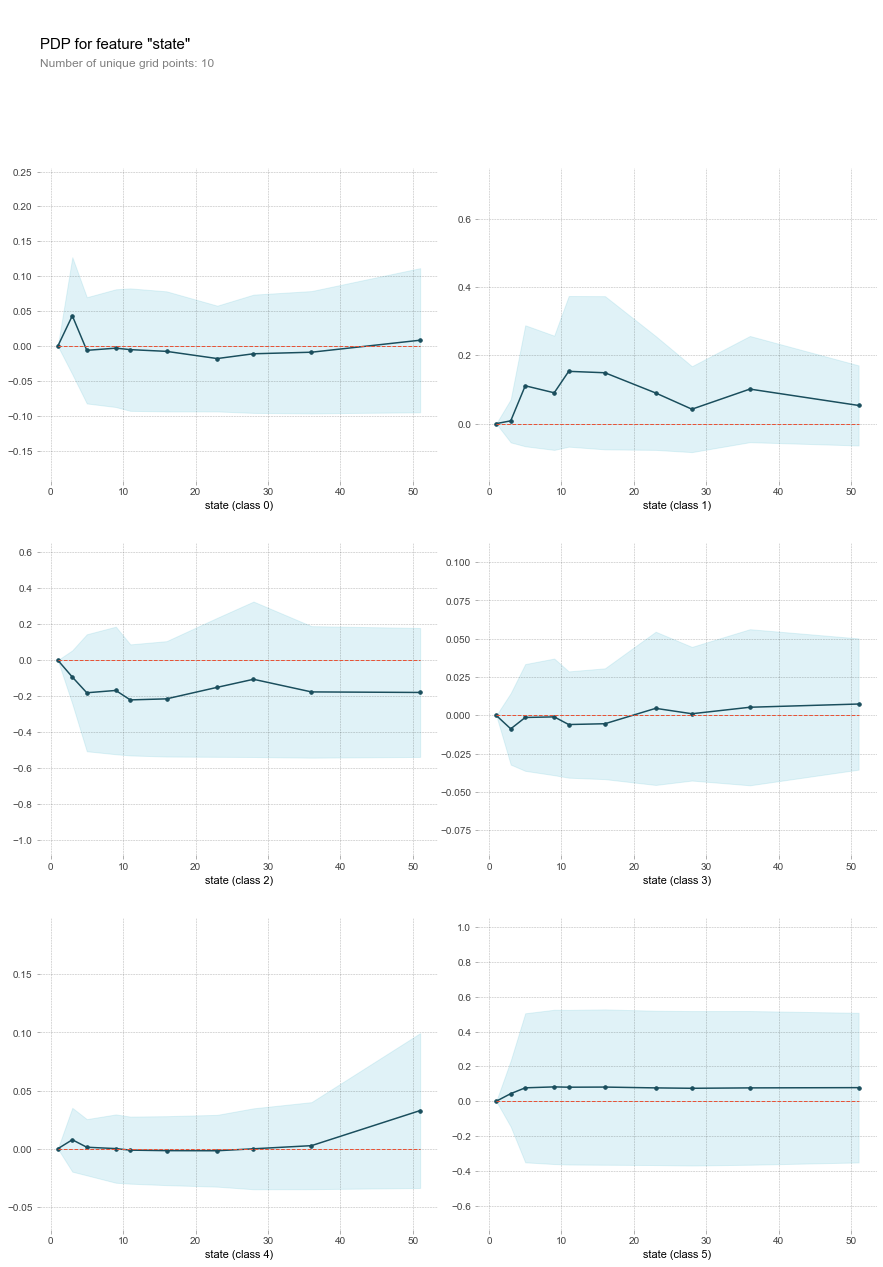

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'state'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

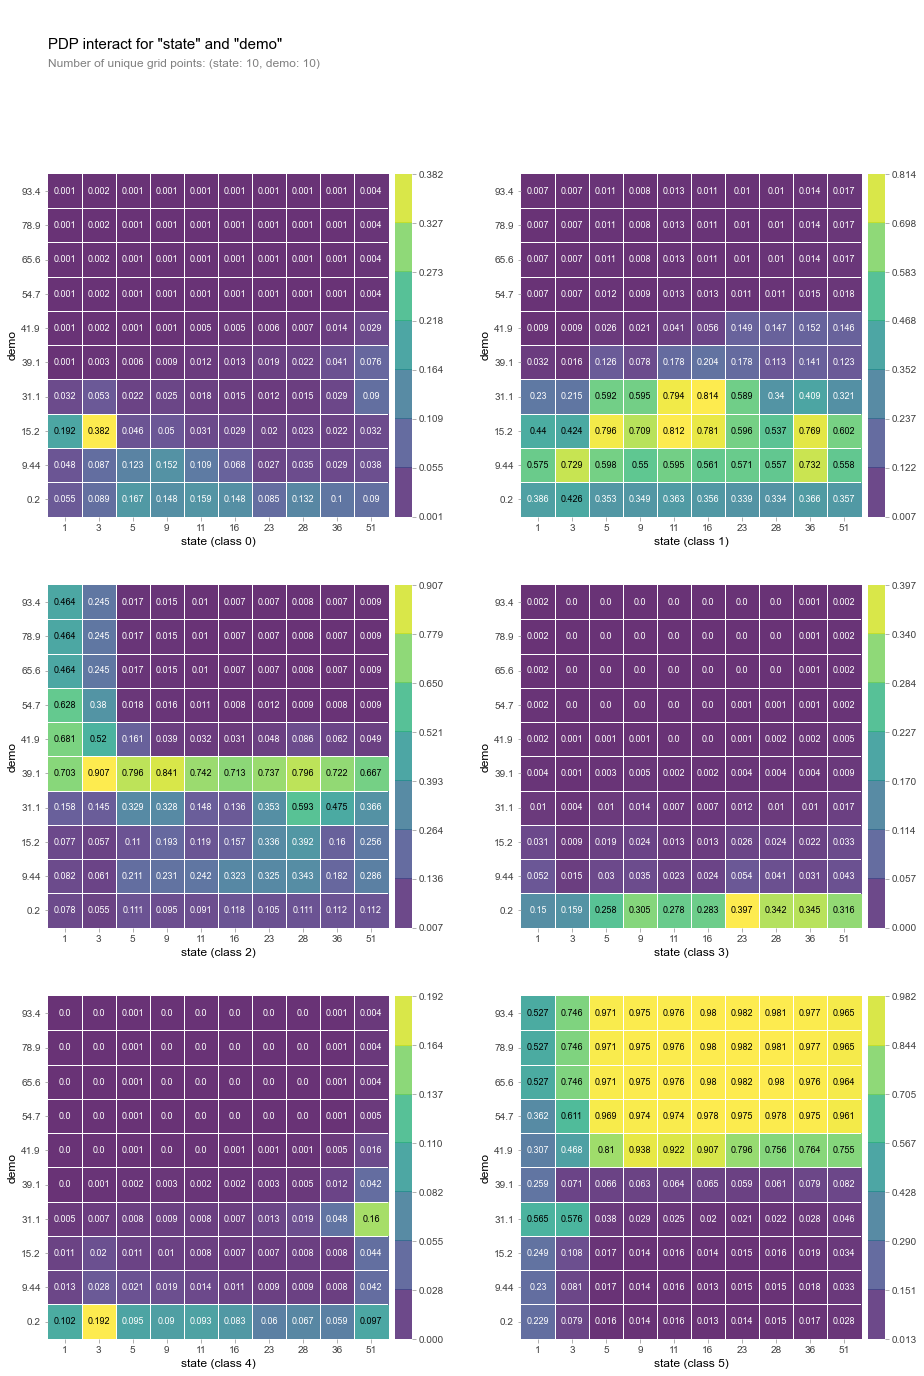

In [67]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['state','demo']
interaction = pdp_interact(model=model,
                          dataset=X_encoded,
                          model_features=X_encoded.columns,
                          features=features)
pdp_interact_plot(interaction, plot_type='grid',feature_names=features);

In [76]:
from xgboost import XGBClassifier
processor = ce.OrdinalEncoder()
X_train_processed = processor.fit_transform(X_train)
#y_train_processed = processor.fit_transform(y_train)
X_val_processed = processor.transform(X_val)
#y_val_processed = processor.transform(y_val)
X_val_processed.shape,X_train_processed.shape,y_train.shape,y_val.shape


((832, 11), (3324, 11), (3324,), (832,))

In [79]:
model = XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_train_processed, y_train)

XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=1)

In [101]:
import shap
row= X_test.iloc[[50]]
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(base_value=explainer.expected_value[0],
                shap_values=shap_values[0],
                features=row,
                link='logit')


In [96]:
len(shap_values)

6

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
          shap_values=shap_values,
          features=row)

In [ ]:
#Rob. Of course this won't work. This is a regression explaination for a classification problem. Idiot.
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'state'
isolated = pdp_isolate(model= xgb,
                       dataset=X_val,
                       model_features=X_val.columns,
                       feature=feature)

In [104]:
washington = df[df['state'] == 'WA']
washington

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
102,138,Antonio Zambrano-Montes,2015-02-10,shot and Tasered,unarmed,35.0,M,H,Pasco,WA,True,other,Foot,False
209,295,Jamison Childress,2015-03-19,shot,unarmed,20.0,M,W,Sumas,WA,True,attack,Not fleeing,False
295,393,Daniel Covarrubias,2015-04-21,shot,unarmed,37.0,M,N,Lakewood,WA,True,other,Foot,False
335,431,Roark Cook,2015-05-04,shot,toy weapon,36.0,M,W,Kennewick,WA,True,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5276,5778,Shaun Lee Fuhr,2020-05-01,shot,unarmed,24.0,M,B,Seattle,WA,False,attack,Foot,True
5279,5781,Said Joquin,2020-05-01,shot,gun,26.0,M,B,Lakewood,WA,False,attack,Not fleeing,False
5297,5802,TK TK,2020-05-06,shot,knife,20.0,M,NaN,Renton,WA,False,other,NaN,False
5330,5822,Juan M. Montalvo,2020-05-17,shot,gun,25.0,M,H,Pasco,WA,False,attack,NaN,False


In [105]:
natives = df[df['race'] == 'N']
natives

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
65,348,Nicolas Leland Tewa,2015-01-27,shot,NaN,26.0,M,N,Phoenix,AZ,False,other,Not fleeing,False
213,531,Justin Fowler,2015-03-20,shot,gun,24.0,M,N,Red Valley,AZ,False,attack,Car,False
295,393,Daniel Covarrubias,2015-04-21,shot,unarmed,37.0,M,N,Lakewood,WA,True,other,Foot,False
438,563,Joe Charboneau,2015-06-16,shot,gun,31.0,M,N,Wood Lake,ND,False,attack,Not fleeing,False
508,628,Paul Castaway,2015-07-12,shot,knife,35.0,M,N,Denver,CO,True,other,Foot,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4639,5490,Anderson Antelope,2019-09-21,shot,knife,58.0,M,N,Riverton,WY,True,attack,Not fleeing,False
4838,5388,Neil Chiago,2019-12-02,shot,gun,18.0,M,N,Mesa,AZ,False,attack,Not fleeing,False
5051,5525,Hans Alejandro Huitz,2020-02-12,shot,gun,51.0,M,N,Virginia Beach,VA,False,attack,Not fleeing,False
5054,5528,Dakota Lee Chlarson,2020-02-13,shot,scissors,25.0,M,N,Dickinson,ND,False,attack,Not fleeing,False


In [114]:
df['body_camera'].value_counts()

False    4792
True      616
Name: body_camera, dtype: int64